## Instalación de librerías 

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book() 
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision.all import *

     |████████████████████████████████| 720 kB 5.3 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
     |████████████████████████████████| 1.2 MB 35.6 MB/s 
     |████████████████████████████████| 186 kB 34.4 MB/s 
     |████████████████████████████████| 56 kB 3.9 MB/s 
     |████████████████████████████████| 51 kB 311 kB/s 
Mounted at /content/gdrive


## Obtención Base de Datos

Se obtendrán las imágenes con la función "search_images_bing". Es una función propia de la librería FastAI. Con una llave de Azure, permite descargar 150 imágenes a partir de un término de búsqueda.

1. Configuración llave de Azure

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY','b09b371fa54c4b44a423452ce0cf2779')

2. Se indican las etiquetas de nuestro conjunto de datos, que serán los términos de búsqueda

In [ ]:
image_types = ['5 euro bill','10 euro bill','20 euro bill','50 euro bill','100 euro bill','200 euro bill','500 euro bill']
path = Path('Data')

3. Creamos los directorios donde se guardarán las imágenes y las descargamos.

In [ ]:
if not path.exists():
  path.mkdir()
  for o in image_types:
    dest = (path/o)
    dest.mkdir(exist_ok = True)
    results = search_images_bing(key,f'{o}')
    download_images(dest, urls = results.attrgot('contentUrl'))

4. Comprobamos que todas las imágenes se han descargado correctamente y pueden abrirse. Eliminamos aquellas que no cumplen el requisito.

In [ ]:
fns = get_image_files(path)
fns

(#1017) [Path('Data/50 euro bill/00000037.jpg'),Path('Data/50 euro bill/00000103.png'),Path('Data/50 euro bill/00000068.jpg'),Path('Data/50 euro bill/00000023.jpg'),Path('Data/50 euro bill/00000106.jpg'),Path('Data/50 euro bill/00000014.jpg'),Path('Data/50 euro bill/00000022.jpg'),Path('Data/50 euro bill/00000018.jpg'),Path('Data/50 euro bill/00000064.jpg'),Path('Data/50 euro bill/00000088.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#4) [Path('Data/200 euro bill/00000094.jpg'),Path('Data/100 euro bill/00000100.jpg'),Path('Data/100 euro bill/00000087.jpg'),Path('Data/100 euro bill/00000135.jpg')]

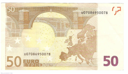

In [ ]:
im = Image.open(fns[100])
im.to_thumb(128,128)

In [ ]:
failed.map(Path.unlink)

(#4) [None,None,None,None]

## De los Datos a DataLoaders

Existen muchos métodos de fábrica para crear estructuras de datos estandarizadas. Cuando se trabaja con un conjunto de datos que no encaja en estos métodos predefinidos, fastAI proporciona una API muy flexible llamada Data Block API. Permite personalizar cada paso de la creación de tu conjunto de datos final antes de entrenar el modelo

In [ ]:
Images = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                  get_items = get_image_files,
                  splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
                  get_y = parent_label,
                  item_tfms = Resize(128))

In [ ]:
dls = Images.dataloaders(path)

Analizamos cómo se ve un Batch cualquiera

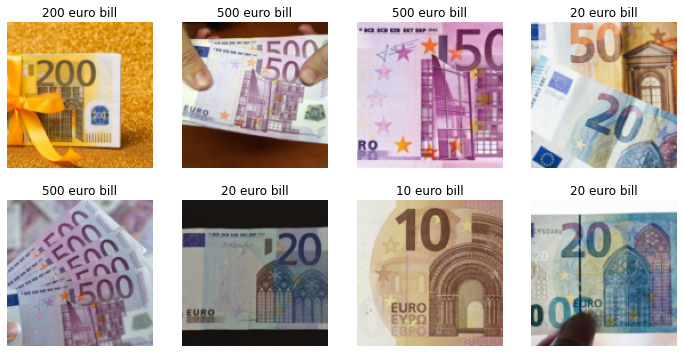

In [ ]:
dls.valid.show_batch(max_n=8,nrows=2)

## Entreno del modelo

El modelo se entrena usando "transfer learning". Se ha cargado un modelo previamente entrenado con otros datos. De esta manera, se necesita menos datos y tiempo para obtener buenos resultados.

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4) #modelo preentrenado - transfer learning

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,2.762088,1.303548,0.435644,00:34


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,1.544460,0.926115,0.297030,00:32
1,1.205124,0.762841,0.232673,00:34
2,0.951268,0.716034,0.212871,00:34
3,0.784731,0.706223,0.207921,00:34


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


## Comprobación resultados

Matriz de Confusión

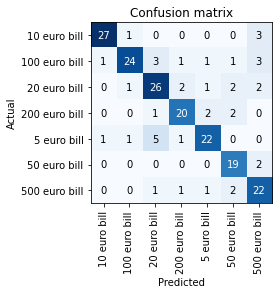

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

La función "plot_top_losses" muestra las imágenes donde se ha obtenido un error más elevado en la función de pérdida. En este caso, se observa que son datos errónos, que no deberían haberse usando para entrenar el modelo.

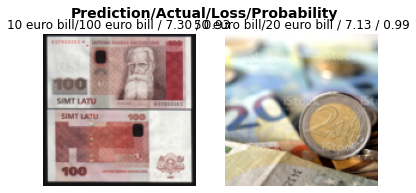

In [ ]:
interp.plot_top_losses(2,nrows=1)

La clase "ImageClassifierCleaner" muestra para cada etiqueta y conjunto de datos (Train o Valid) las imágenes en las que se ha obtenido un mayor error de predicción. Además, permite eliminar las imágenes del conjunto de datos si estas son erróneas o bien cambiar su etiqueta si no están bien etiquetadas.

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


## Uso del modelo para predecir nuevos datos

1. Creación de un botón para poder subir una nueva imagen

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

2. Se muestra la imagen subida

In [ ]:
img = PILImage.create(btn_upload.data[-1])
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

3. Predicción del modelo así como probabilidad de pertenecer a la clase predicha

In [ ]:
pred,pred_idx,probs = learn.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Predicción: {pred}; Probabilidad: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Predicción: 200 euro bill; Probabilidad: 0.9955')

## Exportación del modelo

In [ ]:
learn.export('bill_model.pkl')